In [341]:
%reset -f

In [342]:
#import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the new dataset for bank churn analysis
file_path = 'BankChurners.csv'
bank_data = pd.read_csv(file_path)

#Drop as instructed

bank_data = bank_data.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                            'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],axis=1)



### Skew Analysis

In [343]:
import matplotlib.pyplot as plt
import seaborn as sns

# First, let's identify numerical columns and calculate skewness for each
numerical_cols = bank_data.select_dtypes(include=['int64', 'float64']).columns
skewness = bank_data[numerical_cols].skew()
# print(skewness)

# Now, let's find columns with skewness greater than 1 or less than -1 which indicates significant skewness
skewed_cols = skewness[(skewness > 1) | (skewness < -1)].index

# # Create distribution plots for skewed columns
# for col in skewed_cols:
#     plt.figure(figsize=(8, 4))
#     sns.histplot(bank_data[col], kde=True)
#     plt.title(f'Distribution of {col} (Skewness: {skewness[col]:.2f})')
#     plt.xlabel(col)
#     plt.ylabel('Frequency')
#     plt.show()


In [344]:
# Hyperparameters are set lower than usual as dataset is small and overfitting is a concern
# max_depth default of 6 is causing overfitting

max_depth = 3
learning_rate = 0.1
n_estimators = 100


### Quick Summary of Metrics
Accuracy measures the overall correctness of the model's predictions (the number of correct predictions divided by the total number of predictions). High accuracy on both training and test sets suggests that the model is performing well, but it's always important to consider this metric in the context of the problem's baseline accuracy and the balance of classes in your dataset.

F1 Score is the harmonic mean of precision and recall. It's particularly useful for evaluating models on imbalanced datasets. A high F1 score indicates that the model has a good balance between precision (the model's ability to label negative samples correctly) and recall (the model's ability to find all the positive samples).

ROC AUC (Area Under the Receiver Operating Characteristic Curve) measures the ability of the model to distinguish between the classes. A score closer to 1 indicates that the model has a good measure of separability; it's good at predicting true positives while minimizing false positives.

Log Loss evaluates the accuracy of the probabilistic predictions. It penalizes false classifications more when the model is more confident about its wrong predictions. Lower log loss values are better, indicating higher confidence in the correct predictions.

In [345]:
y = bank_data['Attrition_Flag'].apply(lambda x: 1 if "Attrited Customer" == x else 0)

bank_data_encoded = pd.DataFrame()

label_encoder = LabelEncoder()
for col_name in bank_data:
    if bank_data[col_name].dtype != 'int64' and bank_data[col_name].dtype != 'float64':
        bank_data[col_name+"_encoded"] = label_encoder.fit_transform(bank_data[col_name])
        bank_data_encoded[col_name+"_encoded"] = bank_data[col_name+"_encoded"]
    else:
        bank_data_encoded[col_name] = bank_data[col_name]

X = bank_data_encoded.drop(['Attrition_Flag_encoded','CLIENTNUM'],axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=145, shuffle=True)

xgb_classifier = xgb.XGBClassifier(random_state=145,eval_metric='logloss',use_label_encoder=False,
                                   max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators,verbosity=0,objective='binary:logistic')
xgb_classifier.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

y_train_pred = xgb_classifier.predict(X_train)
y_test_pred = xgb_classifier.predict(X_test)


from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)
logloss_result = xgb_classifier.evals_result()
train_logloss_last = logloss_result['validation_0']['logloss'][-1]
test_logloss_last = logloss_result['validation_1']['logloss'][-1]
# Calculate Lift Score

print(f"""Data Pre-Normalization:
      Train Accuracy: {train_accuracy*100:.2f}%
      Test Accuracy: {test_accuracy*100:.2f}%
      F1 Score: {f1*100:.2f}%
      ROC AUC: {roc_auc*100:.2f}%
      Train Log Loss: {train_logloss_last:.4f}
      Test Log Loss: {test_logloss_last:.4f}""")


Data Pre-Normalization:
      Train Accuracy: 97.51%
      Test Accuracy: 96.64%
      F1 Score: 89.51%
      ROC AUC: 92.11%
      Train Log Loss: 0.0835
      Test Log Loss: 0.1025


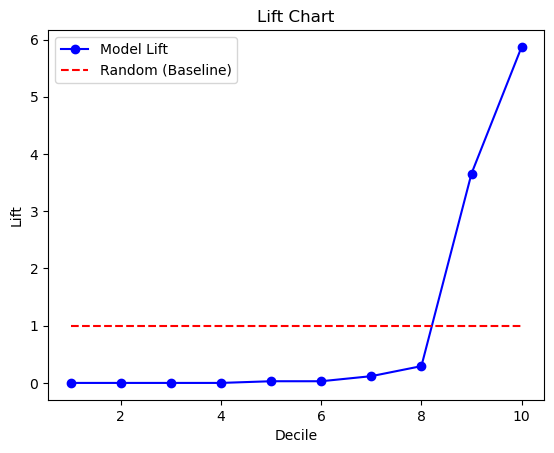

In [346]:
from sklearn.metrics import confusion_matrix

# Example predictions
y_test_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]

# Creating a DataFrame
data = pd.DataFrame({'true': y_test, 'proba': y_test_pred_proba})
data['decile'] = pd.qcut(data['proba'], 10, labels=False)
data.sort_values('proba', ascending=False, inplace=True)
data['cumulative_response'] = data.groupby('decile')['true'].transform(pd.Series.cumsum)
data['cumulative_count'] = data.groupby('decile').cumcount() + 1
data['baseline'] = data['true'].sum() / len(data)
data['lift'] = data['cumulative_response'] / (data['cumulative_count'] * data['baseline'])

# Calculate lift at each decile
lift_at_decile = data.groupby('decile')['lift'].last()

# Plotting
plt.plot(lift_at_decile.index + 1, lift_at_decile, marker='o', linestyle='-', color='b', label='Model Lift')
plt.plot(lift_at_decile.index + 1, np.ones_like(lift_at_decile), color='r', linestyle='--', label='Random (Baseline)')
plt.xlabel('Decile')
plt.ylabel('Lift')
plt.title('Lift Chart')
plt.legend()
plt.show()




### Normalized Data

In [347]:
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew, boxcox
# Apply PowerTransformer to the skewed columns

pt = PowerTransformer()
X_normalized = X.copy()

skewed_cols = skewness[(skewness > 1) | (skewness < -1)].index
# print(skewed_cols)
X_normalized[skewed_cols] = pt.fit_transform(X_normalized[skewed_cols])
X_normalized_train, X_normalized_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=145,shuffle=True)

# for i in skewed_cols:
#     transformed_skew = skew(X_normalized[i])
#     plt.figure(figsize=(8, 4))
#     sns.histplot(X_normalized[i], kde=True)
#     plt.title(f'Distribution of {i} (Skewness: {skew(X_normalized[i]):.2f})')
#     plt.xlabel(i)
#     plt.ylabel('Frequency')
#     plt.show()

xgb_classifier = xgb.XGBClassifier(random_state=145,eval_metric='logloss',use_label_encoder=False,
                                   max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators,verbosity=0,objective='binary:logistic')
xgb_classifier.fit(X_normalized_train, y_train, eval_set=[(X_normalized_train, y_train), (X_normalized_test, y_test)], verbose=False)

y_train_pred = xgb_classifier.predict(X_normalized_train)
y_test_pred = xgb_classifier.predict(X_normalized_test)
#


from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)
logloss_result = xgb_classifier.evals_result()
train_logloss_last = logloss_result['validation_0']['logloss'][-1]
test_logloss_last = logloss_result['validation_1']['logloss'][-1]

print(f"""Data Post-Normalization:
      Train Accuracy: {train_accuracy*100:.2f}%
      Test Accuracy: {test_accuracy*100:.2f}%
      F1 Score: {f1*100:.2f}%
      ROC AUC: {roc_auc*100:.2f}%
      Train Log Loss: {train_logloss_last:.4f}
      Test Log Loss: {test_logloss_last:.4f}""")


Data Post-Normalization:
      Train Accuracy: 97.51%
      Test Accuracy: 96.64%
      F1 Score: 89.51%
      ROC AUC: 92.11%
      Train Log Loss: 0.0835
      Test Log Loss: 0.1025


In [348]:
import pandas as pd
y_test_pred_proba = xgb_classifier.predict_proba(X_normalized_test)[:, 1]

data = pd.DataFrame({'actual': y_test, 'predicted':y_test_pred, 'predicted_proba' :y_test_pred_proba})
data['quintiles'] = pd.qcut(data['predicted_proba'], 5, labels=False)
response_rate = data.groupby('quintiles')['actual'].mean()
overall_response_rate = data['actual'].mean()
# Calculate lift score
lift_score = response_rate / overall_response_rate
lift_score

quintiles
0    0.000000
1    0.000000
2    0.029426
3    0.205984
4    4.767059
Name: actual, dtype: float64

#### Notes:
This shows that there is no real benefit to normalization of the data due to no observable differences.

### Feature Trimming

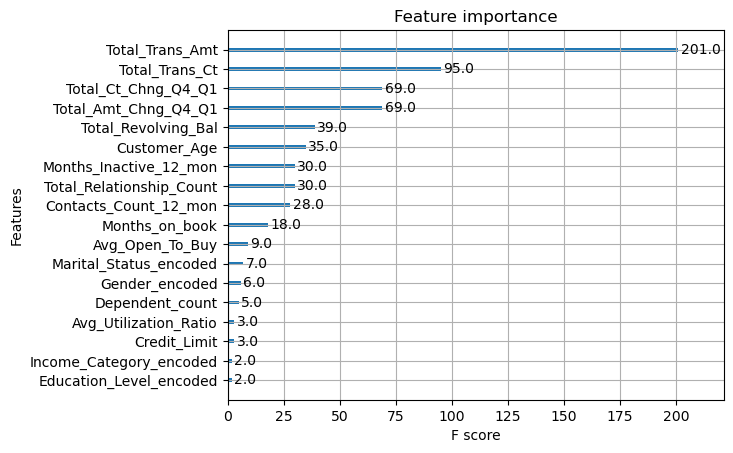

In [349]:
# Feature selection using XGBoost
from xgboost import plot_importance
import matplotlib.pyplot as plt

xgb_classifier = xgb.XGBClassifier(random_state=145,eval_metric='logloss',use_label_encoder=False,
                                   max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators,verbosity=0,objective='binary:logistic')
xgb_classifier.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

plot_importance(xgb_classifier, importance_type='weight')
plt.show()

feature_importance = xgb_classifier.feature_importances_

# Sort by importance

sorted_importance = [x for _, x in sorted(zip(feature_importance, X_train.columns), reverse=True)]

In [350]:
from sklearn.metrics import log_loss

def evaluate_model_with_features(features):
    # Train and evaluate the model with the specified features
    X_train_subset = X_train[features]
    X_test_subset = X_test[features]
    
    xgb_classifier = xgb.XGBClassifier(random_state=145, eval_metric='logloss', use_label_encoder=False,
                                       max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators,verbosity=0,objective='binary:logistic')
    xgb_classifier.fit(X_train_subset, y_train, eval_set=[(X_train_subset, y_train), (X_test_subset, y_test)], verbose=False)
    
    # Making predictions
    y_train_pred = xgb_classifier.predict(X_train_subset)
    y_test_pred = xgb_classifier.predict(X_test_subset)
    y_train_pred_proba = xgb_classifier.predict_proba(X_train_subset)[:,1]
    y_test_pred_proba = xgb_classifier.predict_proba(X_test_subset)[:,1]
    
    # Calculating metrics
    metrics = {
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'F1 Score': f1_score(y_test, y_test_pred),
        'ROC AUC': roc_auc_score(y_test, y_test_pred),
        'Train Log Loss': log_loss(y_train, y_train_pred_proba),
        'Test Log Loss': log_loss(y_test, y_test_pred_proba)
    }
    
    return metrics

# Iterating over features and collecting metrics
all_metrics = []
for i in range(1, len(sorted_importance) + 1):
    features = sorted_importance[:i]
    metrics = evaluate_model_with_features(features)
    all_metrics.append(metrics)


In [351]:
# Convert the list of dictionaries to a DataFrame
import pandas as pd
metrics_df = pd.DataFrame(all_metrics)
metrics_df.index = range(1, len(sorted_importance) + 1) 
metrics_df.index.name = 'Number of Features'
metrics_df

,Train Accuracy,Test Accuracy,F1 Score,ROC AUC,Train Log Loss,Test Log Loss
Number of Features,,,,,,
1,0.847179,0.837117,0.062500,0.515880,0.352586,0.363318
2,0.898161,0.897335,0.663430,0.779822,0.251455,0.264514
3,0.916677,0.908687,0.702093,0.801905,0.214317,0.223449
4,0.925688,0.922507,0.745543,0.824297,0.192854,0.201572
5,0.959511,0.956071,0.862866,0.903164,0.108734,0.122473
6,0.960128,0.955084,0.858915,0.899049,0.105522,0.121284
7,0.961486,0.959033,0.872111,0.908466,0.100831,0.117724
8,0.969016,0.963475,0.886154,0.917005,0.090729,0.107476
9,0.969757,0.964956,0.890601,0.919069,0.091598,0.109043


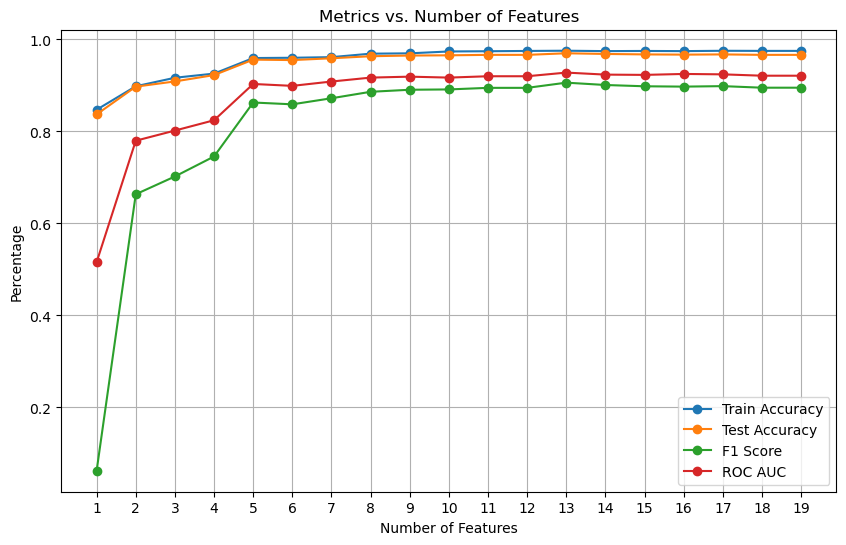

In [352]:
# Example plot for Test Accuracy
plt.figure(figsize=(10, 6))
train_accurracies = [m['Train Accuracy'] for m in all_metrics]
test_accuracies = [m['Test Accuracy'] for m in all_metrics]
f1_scores = [m['F1 Score'] for m in all_metrics]
roc_auc_scores = [m['ROC AUC'] for m in all_metrics]
plt.plot(range(1, len(sorted_importance) + 1), train_accurracies, marker='o', label='Train Accuracy')
plt.plot(range(1, len(sorted_importance) + 1), test_accuracies, marker='o', label='Test Accuracy')
plt.plot(range(1, len(sorted_importance) + 1), f1_scores, marker='o', label='F1 Score')
plt.plot(range(1, len(sorted_importance) + 1), roc_auc_scores, marker='o', label='ROC AUC')
plt.xticks(range(1, len(sorted_importance) + 1))
plt.grid(True)
plt.xlabel('Number of Features')
plt.ylabel('Percentage')
plt.title('Metrics vs. Number of Features')
plt.legend()
plt.show()


#### Notes:
Feature selection seems to suggest having 5-6 features is the most efficient, any other than that and returns will start diminishing

## Trim down to only top 5 features and retrain

In [353]:

# Trim data down to top 5 features
top_5_features = sorted_importance[:5]
X_trim = X.copy()
X_trim = X_trim[top_5_features]
X_trim_train, X_trim_test, y_train, y_test = train_test_split(X_trim, y, test_size=0.2, random_state=145, shuffle=True)
xgb_classifier = xgb.XGBClassifier(random_state=145,eval_metric='logloss',use_label_encoder=False,
                                   max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators,verbosity=0,objective='binary:logistic')
xgb_classifier.fit(X_trim_train, y_train, eval_set=[(X_trim_train, y_train), (X_trim_test, y_test)], verbose=False)

y_train_pred = xgb_classifier.predict(X_trim_train)
y_test_pred = xgb_classifier.predict(X_trim_test)

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)
logloss_result = xgb_classifier.evals_result()
train_logloss_last = logloss_result['validation_0']['logloss'][-1]
test_logloss_last = logloss_result['validation_1']['logloss'][-1]

print(f"""Data Pre-Normalization - Top 5 Features:
      Train Accuracy: {train_accuracy*100:.2f}%
      Test Accuracy: {test_accuracy*100:.2f}%
      F1 Score: {f1*100:.2f}%
      ROC AUC: {roc_auc*100:.2f}%
      Train Log Loss: {train_logloss_last:.4f}
      Test Log Loss: {test_logloss_last:.4f}""")


Data Pre-Normalization - Top 5 Features:
      Train Accuracy: 95.95%
      Test Accuracy: 95.61%
      F1 Score: 86.29%
      ROC AUC: 90.32%
      Train Log Loss: 0.1087
      Test Log Loss: 0.1225


In [354]:
# Reset to original setting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=145, shuffle=True)
# loop for different learning_rate and n_estimators

learning_rates = []
for i in np.arange(0.1,0.6,0.1):
    learning_rates.append(i)
    
n_estimators = []
for i in np.arange(100,600,100):
    n_estimators.append(i)

results = {}
for max_d in [2, 3,4]:
    for lr in learning_rates:
        for n_est in n_estimators:
            xgb_classifier = xgb.XGBClassifier(random_state=145,eval_metric='logloss',use_label_encoder=False,
                                            max_depth=max_d,learning_rate=lr,n_estimators=n_est,verbosity=0,objective='binary:logistic')
            xgb_classifier.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
            y_train_pred = xgb_classifier.predict(X_train)
            y_test_pred = xgb_classifier.predict(X_test)
            y_test_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]
            train_accuracy = accuracy_score(y_train, y_train_pred)
            test_accuracy = accuracy_score(y_test, y_test_pred)
            f1 = f1_score(y_test, y_test_pred)
            roc_auc = roc_auc_score(y_test, y_test_pred)
            logloss_result = xgb_classifier.evals_result()
            train_logloss_last = logloss_result['validation_0']['logloss'][-1]
            test_logloss_last = logloss_result['validation_1']['logloss'][-1]
            results[(max_d,lr, n_est)] = {
                'Train Accuracy': train_accuracy,
                'Test Accuracy': test_accuracy,
                'F1 Score': f1,
                'ROC AUC': roc_auc,
                'Train Log Loss': train_logloss_last,
                'Test Log Loss': test_logloss_last
            }
results_df = pd.DataFrame(results).T
results_df.index.names = ['Max Depth','Learning Rate', 'N Estimators']
results_df['Accuracy_Diff'] = results_df['Train Accuracy'] - results_df['Test Accuracy']
results_df

Train Accuracy  Test Accuracy  F1 Score  \
Max Depth Learning Rate N Estimators                                            
2         0.1           100                 0.960869       0.953110  0.848000   
                        200                 0.972719       0.968411  0.900929   
                        300                 0.978274       0.973346  0.918182   
                        400                 0.982842       0.973840  0.920301   
                        500                 0.984076       0.974334  0.921922   
          0.2           100                 0.972966       0.966930  0.896124   
                        200                 0.982101       0.973346  0.918919   
                        300                 0.986915       0.975321  0.924925   
                        400                 0.990372       0.973346  0.919643   
                        500                 0.992840       0.973346  0.919643   
          0.3           100                 0.977657       0.972359  0.915152   
                        200                 0.986792       0.975321  0.925595   
                        300                 0.991483       0.972853  0.918276   
                        400                 0.995433       0.974334  0.922849   
                        500                 0.997531       0.973840  0.921013   
          0.4           100                 0.980620       0.970385  0.909639   
                        200                 0.989384       0.973346  0.919403   
                        300                 0.994939       0.972359  0.917404   
                        400                 0.997655       0.970879  0.912851   
                        500                 0.999136       0.971372  0.913433   
          0.5           100                 0.984323       0.970879  0.912072   
                        200                 0.993828       0.970879  0.912851   
                        300                 0.997655       0.973840  0.921248   
                        400                 0.999506       0.973840  0.921481   
                        500                 0.999877       0.973840  0.920777   
3         0.1           100                 0.975065       0.966436  0.895062   
                        200                 0.983706       0.973346  0.918429   
                        300                 0.988767       0.971372  0.913174   
                        400                 0.993087       0.972853  0.917788   
                        500                 0.995433       0.974334  0.922156   
          0.2           100                 0.984940       0.973840  0.919575   
                        200                 0.992840       0.972359  0.916168   
                        300                 0.996791       0.973346  0.919162   
                        400                 0.999383       0.973346  0.919643   
                        500                 0.999877       0.971866  0.914798   
          0.3           100                 0.988890       0.972359  0.916168   
                        200                 0.998148       0.974334  0.921922   
                        300                 0.999877       0.974334  0.921922   
                        400                 1.000000       0.971372  0.912913   
                        500                 1.000000       0.970879  0.911011   
          0.4           100                 0.992717       0.976308  0.928783   
                        200                 0.999506       0.974334  0.922849   
                        300                 1.000000       0.974334  0.922619   
                        400                 1.000000       0.973346  0.919403   
                        500                 1.000000       0.973346  0.919403   
          0.5           100                 0.995926       0.972853  0.918759   
                        200                 1.000000       0.973346  0.919643   
                        300                 1.000000       0.972359  

In [355]:
results_df = results_df.sort_values(by =['Accuracy_Diff','F1 Score','Test Accuracy'],ascending=[True,True,False])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Filter for best results
results_df = results_df[(results_df['Accuracy_Diff'] < 0.02) & (results_df['F1 Score'] > 0.91) & (results_df['Test Accuracy'] > 0.97)]
results_df

Train Accuracy  Test Accuracy  F1 Score  \
Max Depth Learning Rate N Estimators                                            
2         0.1           300                 0.978274       0.973346  0.918182   
          0.3           100                 0.977657       0.972359  0.915152   
          0.2           200                 0.982101       0.973346  0.918919   
          0.1           400                 0.982842       0.973840  0.920301   
                        500                 0.984076       0.974334  0.921922   
3         0.1           200                 0.983706       0.973346  0.918429   
          0.2           100                 0.984940       0.973840  0.919575   
2         0.3           200                 0.986792       0.975321  0.925595   
          0.2           300                 0.986915       0.975321  0.924925   
          0.5           100                 0.984323       0.970879  0.912072   
          0.4           200                 0.989384       0.973346  0.919403   
3         0.4           100                 0.992717       0.976308  0.928783   
          0.3           100                 0.988890       0.972359  0.916168   
2         0.2           400                 0.990372       0.973346  0.919643   
3         0.1           300                 0.988767       0.971372  0.913174   
2         0.3           300                 0.991483       0.972853  0.918276   
4         0.1           200                 0.992470       0.973346  0.918675   
          0.2           100                 0.993211       0.973840  0.920777   
2         0.2           500                 0.992840       0.973346  0.919643   

                                       ROC AUC  Train Log Loss  Test Log Loss  \
Max Depth Learning Rate N Estimators                                            
2         0.1           300           0.940547        0.070187       0.088797   
          0.3           100           0.938780        0.068278       0.089562   
          0.2           200           0.944069        0.058237       0.080985   
          0.1           400           0.944365        0.060224       0.082244   
                        500           0.945836        0.053096       0.078101   
3         0.1           200           0.941721        0.055017       0.082214   
          0.2           100           0.940843        0.053545       0.081811   
2         0.3           200           0.951125        0.045650       0.076505   
          0.2           300           0.947603        0.045880       0.075902   
          0.5           100           0.942586        0.048229       0.079974   
          0.4           200           0.946417        0.036961       0.075790   
3         0.4           100           0.954066        0.030200       0.074434   
          0.3           100           0.943476        0.039957       0.078750   
2         0.2           400           0.947591        0.037345       0.074890   
3         0.1           300           0.941709        0.041798       0.075931   
2         0.3           300           0.947294        0.034156       0.073174   
4         0.1           200           0.942895        0.034706       0.076783   
          0.2           100           0.946713        0.033234       0.078163   
2         0.2           500           0.947591        0.030858       0.074024   

                                      Accuracy_Diff  
Max Depth Learning Rate N Estimators                 
2         0.1           300                0.004928  
          0.3           100                0.005298  
          0.2           200                0.008754  
          0.1           400                0.009002  
                        500                0.009742  
3         0.1           200                0.010359  
          0.2           100                0.011100  
2         0.3           200                0.011471  
          0.2           300                0.011594  
          0.5           100             

#### Notes:
Seems like F1 Score will not improve beyond 91%, and the best HyperParamers avaliable is set Max_Depth to 2, Learning_Rate to 0.1, and N estimatiors to 300